In [202]:
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt
import librosa
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, AmplitudeToDB
from synth.synth_constants import synth_structure


from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import seaborn as sns

from config import Config
from synth.synth_architecture import SynthModular

sns.set_style('whitegrid')

n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

# spectrogram = Spectrogram(n_fft=1024)
db = AmplitudeToDB(stype='magnitude')

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", db=True):
    fig, axs = plt.subplots(1, 1, figsize=(30, 15))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    if db:
        im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", cmap='inferno')
    else:
        im = axs.imshow(specgram, origin="lower", aspect="auto", cmap='inferno')
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [232]:
semitones_list = [*range(-24, 24 + 1)]
middle_c_freq= 261.6255653005985
osc_freq_list = [middle_c_freq * (2 ** (1 / 12)) ** x for x in semitones_list]
osc_freq_list

[65.40639132514956,
 69.29565774421792,
 73.41619197935178,
 77.78174593052012,
 82.40688922821737,
 87.30705785825086,
 92.49860567790849,
 97.9988589954372,
 103.82617439498617,
 109.99999999999989,
 116.54094037952234,
 123.4708253140309,
 130.81278265029917,
 138.59131548843592,
 146.83238395870364,
 155.56349186104032,
 164.81377845643482,
 174.6141157165018,
 184.99721135581706,
 195.9977179908745,
 207.65234878997242,
 219.99999999999986,
 233.08188075904485,
 246.94165062806192,
 261.6255653005985,
 277.18263097687196,
 293.6647679174074,
 311.1269837220808,
 329.62755691286986,
 349.22823143300377,
 369.9944227116343,
 391.9954359817492,
 415.30469757994507,
 439.99999999999994,
 466.1637615180899,
 493.8833012561241,
 523.2511306011972,
 554.3652619537442,
 587.3295358348153,
 622.253967444162,
 659.2551138257401,
 698.4564628660079,
 739.9888454232689,
 783.9908719634988,
 830.6093951598906,
 880.0000000000003,
 932.3275230361803,
 987.7666025122487,
 1046.5022612023952]

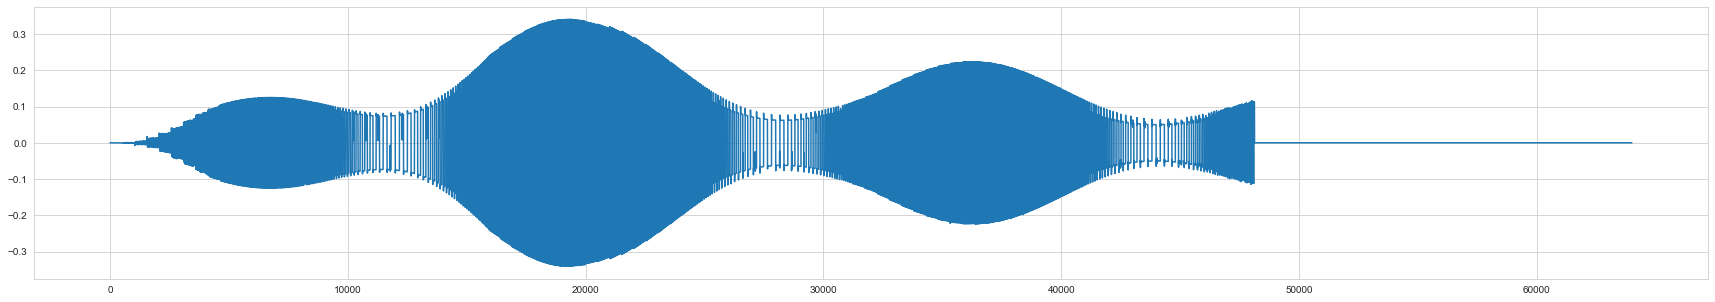

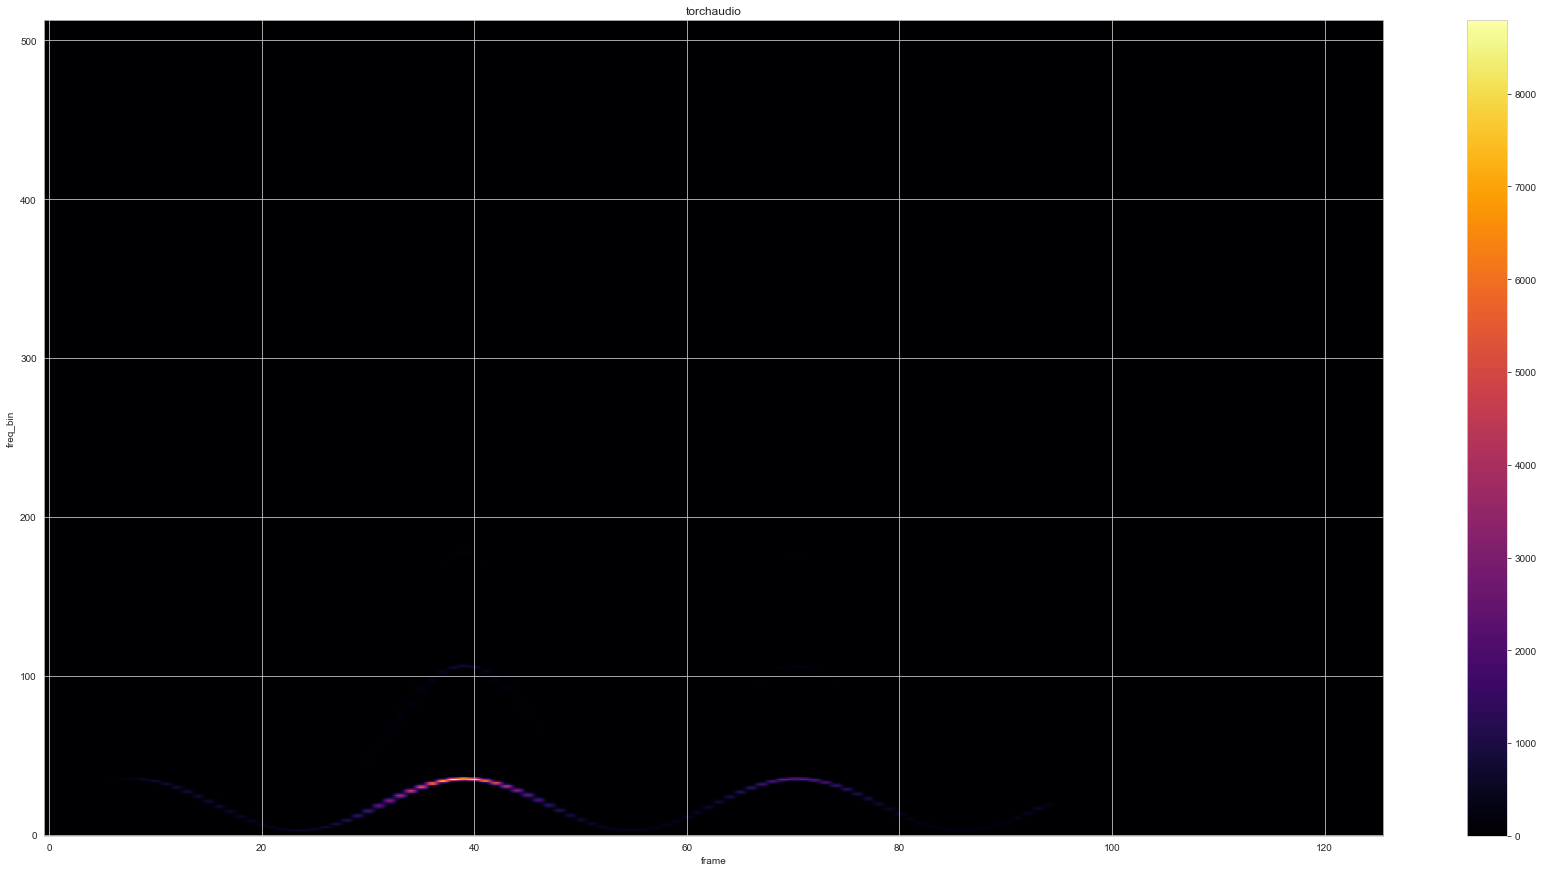

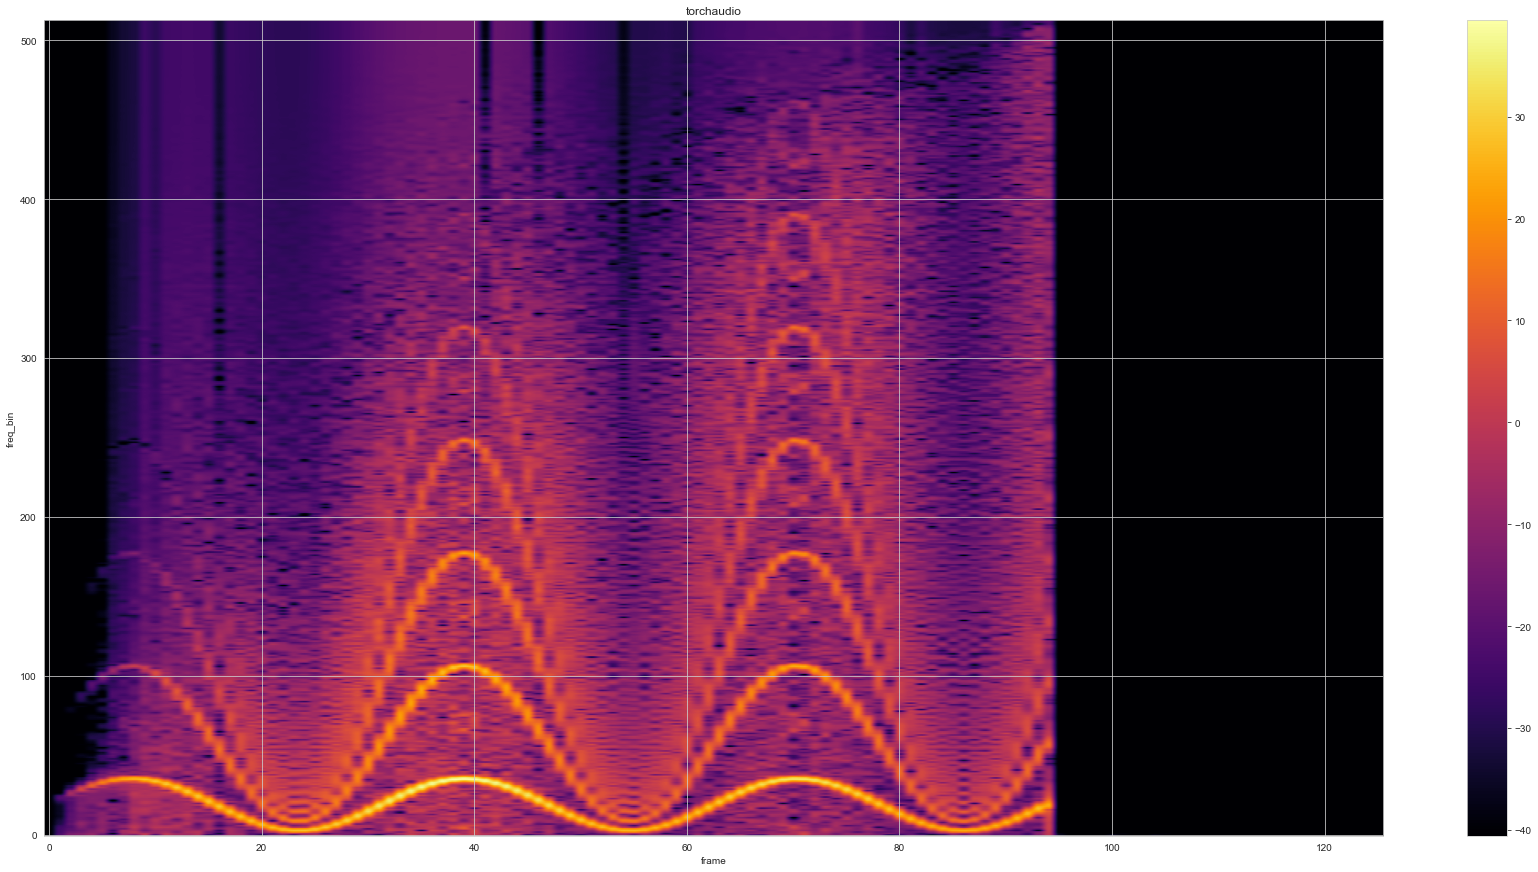

In [340]:
cfg = Config()

# synth_obj = SynthModular(synth_cfg=synth_cfg,
#                          sample_rate=cfg.sample_rate,
#                          signal_duration_sec=cfg.signal_duration_sec,
#                          num_sounds=1,
#                          device='cpu',
#                          preset='MODULAR_NEW')

synth_obj = SynthModular(preset_name='MODULAR_NEW', synth_structure=synth_structure, device='cpu')


params = {(0,0): {'operation': 'lfo_sine', 'parameters': {'freq': [1], 'amp': [1], 'active': [True], 'output': [[0, 6]]}},
          (1,1): {'operation': 'fm_lfo', 'parameters': {'freq_c': [1], 'waveform': ['sine'], 'mod_index': [0], 'amp_c': [1], 'active': [True], 'fm_active': [False], 'output': [[0, 2]]}},
          (0,2): {'operation': 'fm_sine', 'parameters': {'amp_c': [1], 'freq_c': [1046], 'mod_index': [0.3], 'active': [False], 'fm_active': [False]}},
          (1,2): {'operation': 'fm_saw', 'parameters': {'amp_c': [1], 'freq_c': [300], 'mod_index': [0.1], 'active': [False], 'fm_active': [False]}},
          (2,2): {'operation': 'fm_square', 'parameters': {'amp_c': [1], 'freq_c': [300], 'mod_index': [0.1], 'active': [True], 'fm_active': [True]}},
          (0,3): {'operation': 'mix', 'parameters': {}},
          (0,4): {'operation': 'env_adsr', 'parameters': {'attack_t': [1], 'decay_t': [1], 'sustain_t': [1], 'sustain_level': [0.5], 'release_t': [1]}},
          (0,5): {'operation': 'lowpass_filter_adsr', 'parameters': {'attack_t': [3], 'decay_t': [0], 'sustain_t': [0], 'sustain_level': [0.2], 'release_t': [0], 'filter_freq': [1], 'intensity': [1]}},
          (0,6): {'operation': 'tremolo', 'parameters': {'amount': [0.7], 'active': [True], 'fm_active': [True]}}
          }

synth_obj.update_cells_from_dict(params)
final_signal, output_signals_through_chain_dict = synth_obj.generate_signal(signal_duration=4, batch_size=1)
sound = final_signal.detach().cpu()[0]

spec = spectrogram(sound)
db_spec = db(spec)


fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.plot(sound.numpy())

plot_spectrogram(spec, title="torchaudio", db=False)
plot_spectrogram(spec, title="torchaudio")

# NOTES:
# fmactive = true and active = false on sine wave results different behavior that shall be eliminated
# debug filter adsr
# show signals through chain
# add sound button

In [ ]:


# fig2, ax2 = plt.subplots(1, 1, figsize=(20, 20))
# im2 = ax2.imshow(spec.numpy(), origin='lower', aspect='auto', cmap='inferno')
# fig2.colorbar(im2, ax=ax2)
#
#
# fig3, ax3 = plt.subplots(1, 1, figsize=(20, 20))
# im3 = ax3.imshow(db_spec.numpy(), origin='lower', aspect='auto', cmap='inferno')
# fig3.colorbar(im3, ax=ax3)

plt.show()